# MNIST Label Corruption Experiment
This experiment measures the robustness of a supervised classification neural network to varying levels of corruption of the labels on MNIST.

Hypothesis: a NN classifier will be robust to label corruption.
Results: a NN classifier on MNIST is robust up to 70% label corruption, afterwards it quickly falls off.

In [56]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [57]:
# setup training data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [58]:
# create corrupted training data by randomly changing the labels
corrupt_levels = np.arange(0.0,1.0,0.1)
corrupted_data = {}
labels = list(np.unique(y_train))
for level in corrupt_levels:
  y_train_corrupt = y_train.copy()
  for idx, y_label in enumerate(y_train_corrupt):
    if np.random.uniform() < level:
      labels.remove(y_label)
      y_train_corrupt[idx] = random.choice(labels)
      labels.append(y_label)
  corrupted_data[level] = y_train_corrupt

# check corruption is correct
delta = 0.02
for level, y_corrupt in corrupted_data.items():
  diff_pct = np.equal(corrupted_data[level], y_train).sum()/y_train.shape[0]
  assert (diff_pct < 1.0 - level + delta) and (diff_pct > 1.0 - level - delta)

In [59]:
# define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# define predictions
predictions = model(x_train[:1]).numpy()
predictions
tf.nn.softmax(predictions).numpy()

# set loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# before training loss should be random ~log(1/10) ~= 2.3
print(loss_fn(y_train[:1], predictions).numpy())

# compile the model
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

1.9448756


In [60]:
# fit the model to training data
metrics = {}
for level, y_labels in corrupted_data.items():
  tf.keras.backend.clear_session()
  print(f'Training at corruption level {level}')
  model.fit(x_train, y_labels, epochs=5)
  metrics[level] = model.evaluate(x_test,  y_test, verbose=2)

Training at corruption level 0.0
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2957 - accuracy: 0.9141
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1416 - accuracy: 0.9572
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1043 - accuracy: 0.9681
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0851 - accuracy: 0.9736
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0727 - accuracy: 0.9774
313/313 - 1s - loss: 0.0752 - accuracy: 0.9772 - 655ms/epoch - 2ms/step
Training at corruption level 0.1
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8015 - accuracy: 0.8634
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7181 - accuracy: 0.8711
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6933 - accuracy: 0.8728
Epoch 4/5
1875/1875 [==============================] -

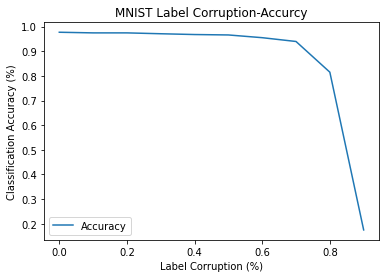

In [61]:
x,y = [],[]
for l, m in metrics.items():
  x.append(l)
  y.append(m[1])
plt.plot(x, y, label="Accuracy")
plt.plot()

plt.xlabel("Label Corruption (%)")
plt.ylabel("Classification Accuracy (%)")
plt.title("MNIST Label Corruption-Accurcy")
plt.legend()
plt.show()